
# Graph Classification with DGL

- This tutorial demonstrates . 

In this tutorial, you will learn:
* Prepare training and testing sets for graph classification task.
* Prepar
* Build a GNN-based graph classification  model.
* Train the model and verify the result.

In [1]:
import dgl
from dgl.data import TUDataset
from dgl.data.utils import split_dataset
from dgl.nn.pytorch import conv
import numpy as np
import networkx as nx

import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torch.nn.functional as F

Using backend: pytorch


## Problem formulation

- Given a set of training graphs with their labels
- Predict the labels on the graphs in the test set

## Load enzyme dataset

<img src="../asset/enzymes.png" width="500"/>

- Constructs graphs from the enzymes based on group functions. 
- Nodes represent structure elements and edges denote the connections between them.
- Each graph has a label from 0-5, which means the type of the enzymes.

In [2]:
dataset = TUDataset("ENZYMES")

dataset.graph_labels=torch.tensor(dataset.graph_labels)
# Cast the node attributes in float format
for i in range(len(dataset)):
    dataset[i][0].ndata['node_attr']=(dataset[i][0].ndata['node_attr']).float()

/home/ubuntu/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
graph, label= dataset[0]
print(graph)
print(label)

Graph(num_nodes=37, num_edges=168,
      ndata_schemes={'node_labels': Scheme(shape=(1,), dtype=torch.int64), 'node_attr': Scheme(shape=(18,), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64)})
tensor([5])


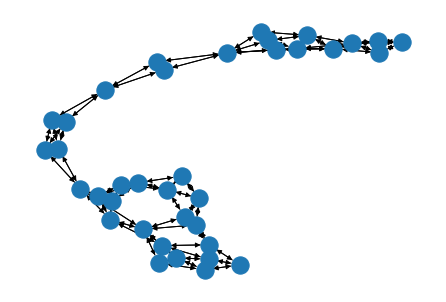

In [4]:
nx.draw_spring(graph.to_networkx())

### Split dataset into train and val

In [5]:
trainset, valset = split_dataset(dataset, [0.8, 0.2], shuffle=True, random_state=42)

## Construct training loop

- The dataset consist of multiple graphs.
- Executing a forward pass with all graphs simultaneously might exceed the GPU memory capacity

### Minibatch training 101

- Mini-batch training constructs batches of graphs.
- Per training epoch multiple mini-batches are constructed.
- The forward pass is executed per mini-batch.
- More details in the large-scale training tutorial

### Prepare Graph Classification Dataloader

- Dataloader specifies how the mini-batches will be constructed.
- DGL could batch multiple small graphs together to accelerate the computation.
- dgl.batch(): Combines the graphs in the minibatch into a single graph.
- Detail of batching can be found [here](https://docs.dgl.ai/tutorials/basics/4_batch.html).

<img src="https://data.dgl.ai/tutorial/batch/batch.png" width="500"/>

In [6]:
def collate_molgraphs_for_classification(data):
    """Batching a list of datapoints for dataloader in classification tasks."""
    graphs, labels = map(list, zip(*data))
    bg = dgl.batch(graphs)
    labels = torch.stack(labels, dim=0)
    return bg, labels

train_loader = DataLoader(trainset, batch_size=512,
                          collate_fn=collate_molgraphs_for_classification)
val_loader = DataLoader(valset, batch_size=512,
                        collate_fn=collate_molgraphs_for_classification)

## Graph Classification GCN Model

- Two layer GCN is used to classify the graphs.
- Detailed source code can be found [here](https://github.com/dmlc/dgl/blob/master/python/dgl/model_zoo/chem/classifiers.py#L111).

- 3-layer GCN to learn the node-level representations. 
- Readout functions `dgl.sum_nodes`, suming all the node(vertex) representation to get the graph representsions. $h_g=\sum{h_v}$
- $h_g$ is fed to a linear(MLP) classifier to classify the graph based on its representation

In [7]:
class GCNModel(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 out_feats):
        super().__init__()
        self.layers = nn.ModuleList([
            conv.GraphConv(in_feats, n_hidden, activation=F.relu, allow_zero_in_degree=True),
            conv.GraphConv(n_hidden, n_hidden, activation=F.relu, allow_zero_in_degree=True),
            conv.GraphConv(n_hidden, n_hidden, activation=F.relu, allow_zero_in_degree=True)
        ])
        
        self.classifier = nn.Linear(n_hidden, out_feats)

    def forward(self, g, features):
        h = features
        for layer in self.layers:
            h = layer(g, h)
        with g.local_scope():
            g.ndata['feat'] = h
            h_g = dgl.sum_nodes(g, 'feat')
        return self.classifier(h_g)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
epochs = 500
model = GCNModel(in_feats=18, n_hidden=64, out_feats=6).to(device)
loss_criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())
print(device)
print(model)

cuda
GCNModel(
  (layers): ModuleList(
    (0): GraphConv(in=18, out=64, normalization=both, activation=<function relu at 0x7f6358344ea0>)
    (1): GraphConv(in=64, out=64, normalization=both, activation=<function relu at 0x7f6358344ea0>)
    (2): GraphConv(in=64, out=64, normalization=both, activation=<function relu at 0x7f6358344ea0>)
  )
  (classifier): Linear(in_features=64, out_features=6, bias=True)
)


## Training

In [9]:
model.train()
for i in range(epochs):
    loss_list = []
    true_samples = 0
    num_samples = 0
    for batch_id, batch_data in enumerate(train_loader):
        bg, labels = batch_data
        atom_feats = bg.ndata.pop('node_attr').float()
        bg=bg.to(device)
        atom_feats, labels = atom_feats.to(device), \
                                   labels.to(device).squeeze(-1)
        logits = model(bg, atom_feats)
        loss = loss_criterion(logits, labels)
        true_samples += (logits.argmax(1)==labels.long()).float().sum().item()
        num_samples += len(labels)
        loss_list.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i%100==0:
        print("Epoch {:05d} | Loss: {:.4f} | Accuracy: {:.4f}".format(i, np.mean(loss_list), true_samples/num_samples))

Epoch 00000 | Loss: 163.4622 | Accuracy: 0.1729
Epoch 00100 | Loss: 1.9747 | Accuracy: 0.2792
Epoch 00200 | Loss: 4.3967 | Accuracy: 0.1833
Epoch 00300 | Loss: 1.5398 | Accuracy: 0.4042
Epoch 00400 | Loss: 1.4907 | Accuracy: 0.4083


## Validation

In [10]:
model.eval()
true_samples = 0
num_samples = 0
with torch.no_grad():
    for batch_id, batch_data in enumerate(val_loader):
        bg, labels = batch_data
        bg=bg.to(device)
        atom_feats = bg.ndata.pop('node_attr')
        atom_feats, labels = atom_feats.to(device), \
                                   labels.to(device).squeeze(-1)
        logits = model(bg, atom_feats)
        logits.argmax()
        num_samples += len(labels)
        true_samples += (logits.argmax(1)==labels.long()).float().sum().item()
print("Validation Accuracy: {:.4f}".format(true_samples/num_samples))

Validation Accuracy: 0.3417
